In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


import warnings
warnings.filterwarnings('ignore')



In [3]:
df_o = pd.read_csv("data/Train.csv")
df_o.head(2)

,ID,DATOP,FLTID,DEPSTN,ARRSTN,STD,STA,STATUS,AC,target
0,train_id_0,2016-01-03,TU 0712,CMN,TUN,2016-01-03 10:30:00,2016-01-03 12.55.00,ATA,TU 32AIMN,260.0
1,train_id_1,2016-01-13,TU 0757,MXP,TUN,2016-01-13 15:05:00,2016-01-13 16.55.00,ATA,TU 31BIMO,20.0


+ DATOP - Date of flight,
+ FLTID - Flight number,
+ DEPSTN - departure destination,
+ ARRSTN - Arrival destination,
+ STD - Scheduled Time departure,
+ STA - Scheduled Time arrival,
+ STATUS - Flight status,
+ AC - Aircraft Code,

In [4]:
# data cleaning
df = df_o.copy()
df.STD = pd.to_datetime(df.STD, format = '%Y-%m-%d %H:%M:%S') 
df.DATOP = pd.to_datetime(df.DATOP, format = '%Y-%m-%d') 
df.STA = pd.to_datetime(df.STA, format = '%Y-%m-%d %H.%M.%S') 
df['departure_time'] = df.STD.dt.hour #  * 60 + df.STD.dt.minute # departure time in minutes
df['duration'] = df.STA - df.STD
df = df[df['duration']< '1 days']
df = df[df.target < 60*12]
df['departure_month'] = df.STD.dt.month
df['departure_year'] = df.STD.dt.year
df['day_of_week'] = df.STD.dt.day_of_week
df.FLTID = df.FLTID.str.strip()
df.info()



<class 'pandas.core.frame.DataFrame'>
Index: 107022 entries, 0 to 107832
Data columns (total 15 columns):
 #   Column           Non-Null Count   Dtype          
---  ------           --------------   -----          
 0   ID               107022 non-null  object         
 1   DATOP            107022 non-null  datetime64[ns] 
 2   FLTID            107022 non-null  object         
 3   DEPSTN           107022 non-null  object         
 4   ARRSTN           107022 non-null  object         
 5   STD              107022 non-null  datetime64[ns] 
 6   STA              107022 non-null  datetime64[ns] 
 7   STATUS           107022 non-null  object         
 8   AC               107022 non-null  object         
 9   target           107022 non-null  float64        
 10  departure_time   107022 non-null  int32          
 11  duration         107022 non-null  timedelta64[ns]
 12  departure_month  107022 non-null  int32          
 13  departure_year   107022 non-null  int32          
 14  day_of_we

Text(0.5, 0, 'departure_time [hour of the day]')

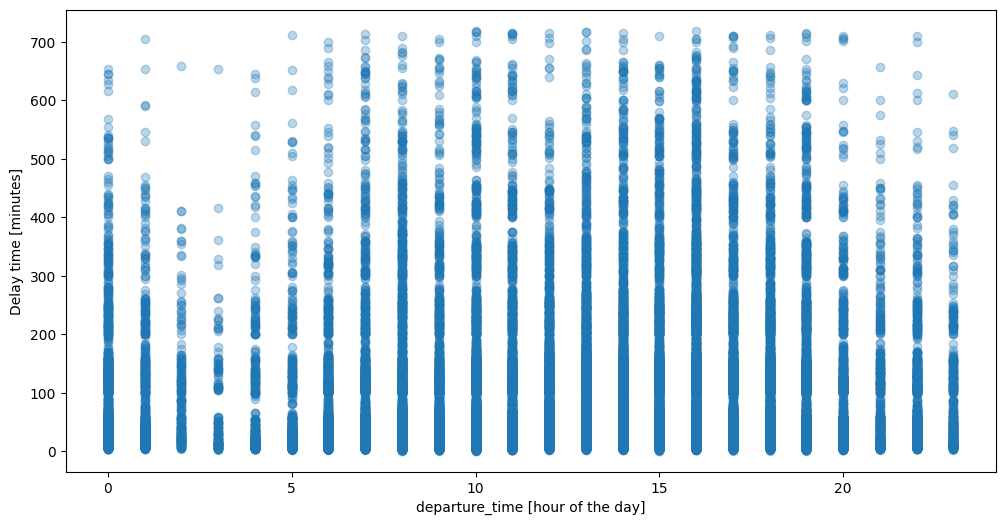

In [5]:
plt.figure(1, figsize=(12,6))
plt.scatter(df[df.target>0].departure_time, df[df.target>0].target,  alpha = 0.3)
plt.ylabel('Delay time [minutes]')
plt.xlabel('departure_time [hour of the day]')
# plt.legend()


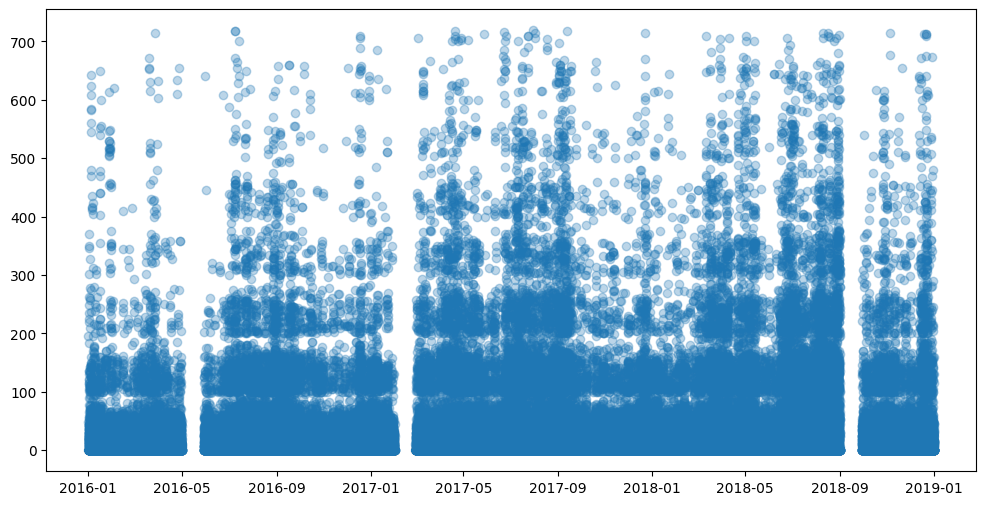

In [6]:
fig= plt.figure(1, figsize=(12,6))
plt.plot_date(df.STD, df.target, fmt='o',alpha=0.3)
# plt.plA, df.target, fmt='bo',alpha=0.2)

Text(0.5, 0, 'arrival date')

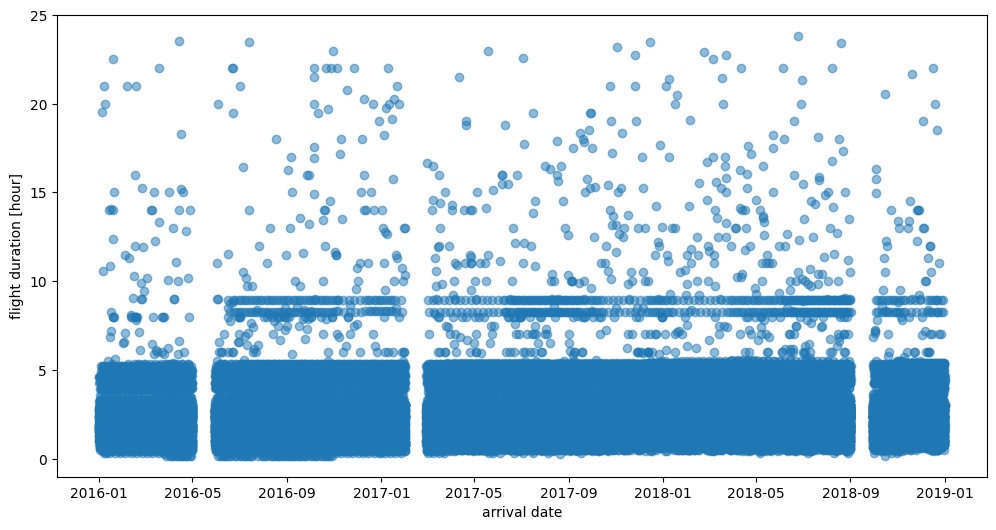

In [7]:
fig = plt.figure(1, figsize=(12,6))
plt.plot_date(df.STA, df.duration.dt.total_seconds()/3600, fmt='o',alpha=0.5)
plt.ylabel('flight duration [hour]')
plt.xlabel('arrival date')


Text(0.5, 0, 'departure_month')

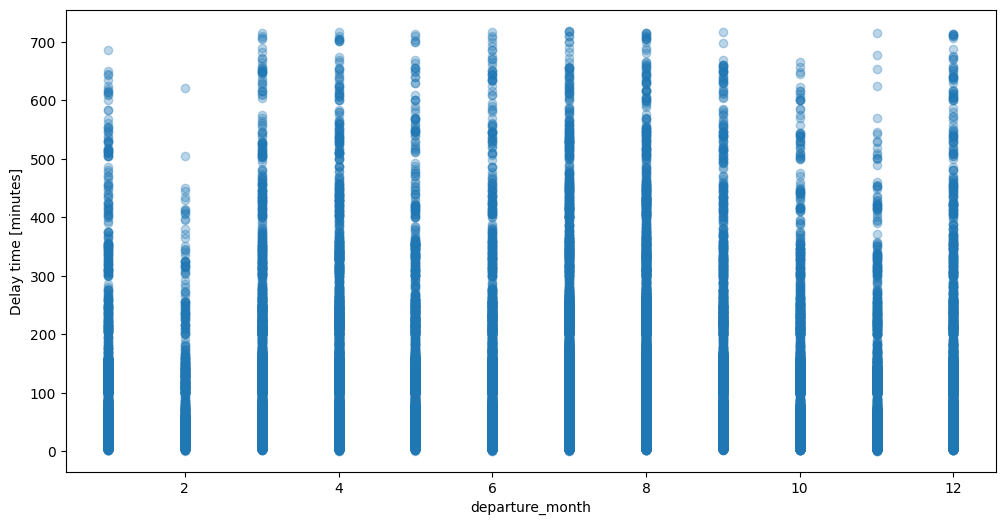

In [8]:
plt.figure(1, figsize=(12,6))
plt.scatter(df[df.target>0].departure_month, df[df.target>0].target,  alpha = 0.3)
# plt.title(label)
plt.ylabel('Delay time [minutes]')
plt.xlabel('departure_month')

In [9]:
# from sklearn.preprocessing import LabelEncoder
# # Label Encoding
# label_encoder = LabelEncoder()
# df['flight_id'] = label_encoder.fit_transform(df['FLTID'])
# df['departure_port'] = label_encoder.fit_transform(df['DEPSTN'])
# df['arrival_port'] = label_encoder.fit_transform(df['ARRSTN'])
# df['status'] = label_encoder.fit_transform(df['STATUS'])
# df['aircraft_code'] = label_encoder.fit_transform(df['AC'])
df['duration_min'] =df.duration.dt.total_seconds()/60


# df[df['STATUS']=='DEL'].head() #.target.unique() # #['ATA', 'DEP', 'RTR', 'SCH', 'DEL']
# # df[df['STATUS']=='ATA'].target.unique() #[['STATUS','target']]

## choose columns 

In [10]:
from sklearn.model_selection import train_test_split
X= df[['FLTID',  'departure_year','day_of_week',
       'AC',  'departure_time',  'departure_month'
        ]]
y=df.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=12)

## One hot encoding

In [11]:
from sklearn.preprocessing import OneHotEncoder

onehe = OneHotEncoder(sparse_output= False, drop= 'first',handle_unknown='ignore')
onehe.fit(X_train)
X_train = onehe.transform(X_train)

In [12]:
X_test = onehe.transform(X_test)


## Trainining the model

In [13]:
#training the model
from sklearn.linear_model import LinearRegression

model = LinearRegression()
reg = model.fit(X_train, y_train)

In [14]:
from sklearn.metrics import mean_squared_error,r2_score
y_train_pred = reg.predict(X_train)
mse = mean_squared_error(y_train, y_train_pred)
print(np.sqrt(mse))
r2_score(y_train, y_train_pred)

77.47156392310403


0.1702129375683996

In [15]:
y_pred = reg.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(np.sqrt(mse))
r2_score(y_test, y_pred)

79.72542675527903


0.12510428245669436

## Ridge regression

In [16]:
from sklearn.linear_model import Ridge

ridge_model = Ridge(alpha=15.0)  #  regularization strength 
ridge_model.fit(X_train, y_train)

Ridge(alpha=15.0)

In [17]:
# alpha = 15
y_train_pred = ridge_model.predict(X_train)
mse = mean_squared_error(y_train, y_train_pred)
print("rmse train:", np.sqrt(mse))
r2 = r2_score(y_train, y_train_pred)
print("R2 train:", r2)

# test set fitting
y_pred = ridge_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("rmse:", np.sqrt(mse))
r2 = r2_score(y_test, y_pred)
print("R2 test:", r2)



rmse train: 78.49048270670033
R2 train: 0.14824240891568874
rmse: 79.05206051049124
R2 test: 0.13982072543672908


## Lasso regression

In [18]:
from sklearn.linear_model import Lasso

lasso_model = Lasso(alpha=10)  
lasso_model.fit(X_train, y_train)

Lasso(alpha=10)

In [19]:
# alpha = 10
y_train_pred = lasso_model.predict(X_train)
mse = mean_squared_error(y_train, y_train_pred)
print("rmse train:", np.sqrt(mse))
r2 = r2_score(y_train, y_train_pred)
print("R2 train:", r2)

# test set fitting
y_pred = lasso_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("rmse:", np.sqrt(mse))
r2 = r2_score(y_test, y_pred)
print("R2 test:", r2)

rmse train: 85.04699900096804
R2 train: 0.0
rmse: 85.23977665174154
R2 test: -0.00010866877755866255


## Random forest

In [20]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=65)
rf_regressor.fit(X_train, y_train)

RandomForestRegressor(random_state=65)

In [21]:
y_pred = rf_regressor.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(np.sqrt(mse))

83.04656759237582


In [22]:
y_train_pred = rf_regressor.predict(X_train)
mse = mean_squared_error(y_train, y_train_pred)
print("rmse train:", np.sqrt(mse))
r2 = r2_score(y_train, y_train_pred)
print("R2 train:", r2)

rmse train: 36.557032439619014
R2 train: 0.815233223875763


Text(0.5, 1.0, 'Actual vs. Predicted Values (Random Forest)')

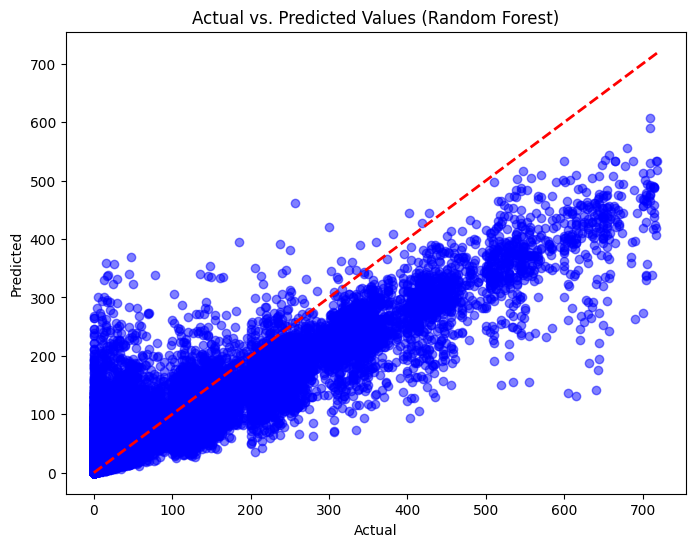

In [23]:
plt.figure(figsize=(8, 6))
plt.scatter(y_train, y_train_pred, color='blue', alpha=0.5)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], color='red', linestyle='--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted Values (Random Forest)')


In [24]:
# test set fitting
y_pred = rf_regressor.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("rmse:", np.sqrt(mse))
r2 = r2_score(y_test, y_pred)
print("R2 test:", r2)

rmse: 83.04656759237582
R2 test: 0.05069458085045031


Text(0.5, 1.0, 'Actual vs. Predicted Values (Random Forest)')

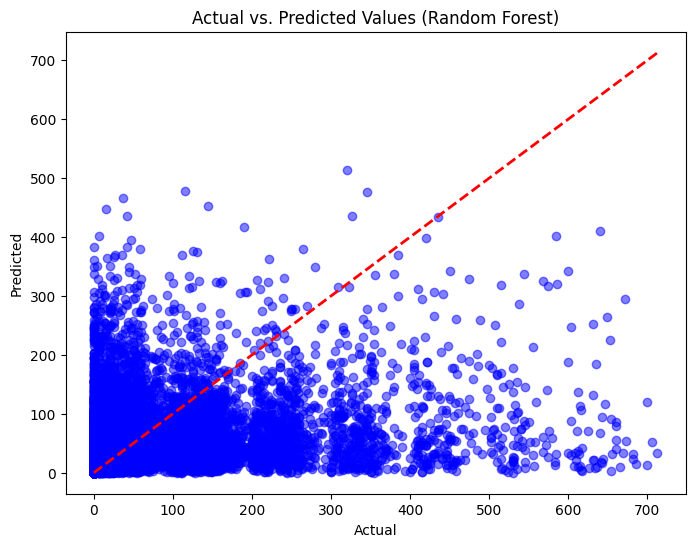

In [25]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted Values (Random Forest)')

In [39]:
rf_regressor = RandomForestRegressor(n_estimators=80, max_depth = 15, random_state=65)
rf_regressor.fit(X_train, y_train)

RandomForestRegressor(max_depth=15, n_estimators=80, random_state=65)

In [40]:
y_train_pred = rf_regressor.predict(X_train)
mse = mean_squared_error(y_train, y_train_pred)
print("rmse train:", np.sqrt(mse))
r2 = r2_score(y_train, y_train_pred)
print("R2 train:", r2)
# test set fitting
y_pred = rf_regressor.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("rmse test:", np.sqrt(mse))
r2 = r2_score(y_test, y_pred)
print("R2 test:", r2)

rmse train: 76.79624564719659
R2 train: 0.1846163643417572
rmse test: 80.53007152368852
R2 test: 0.10735504431744503


Text(0.5, 1.0, 'Actual vs. Predicted Values (Random Forest)')

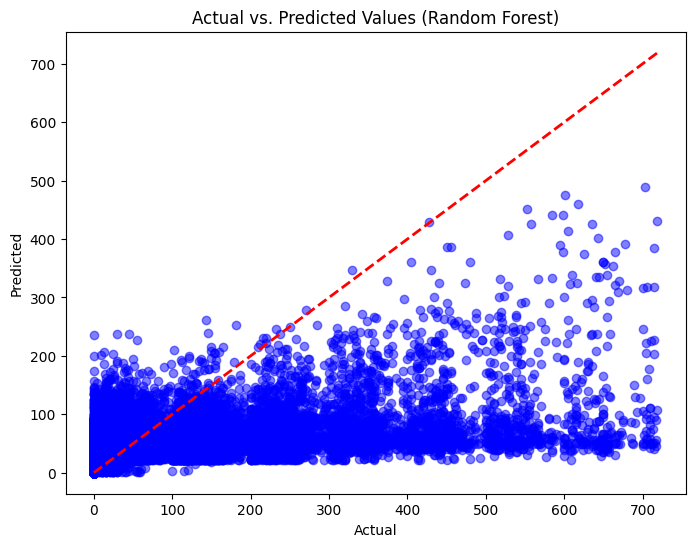

In [41]:
plt.figure(figsize=(8, 6))
plt.scatter(y_train, y_train_pred, color='blue', alpha=0.5)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], color='red', linestyle='--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted Values (Random Forest)')


In [42]:

pd.DataFrame({'original test set':y_test, 'predictions': y_pred})

,original test set,predictions
44205,27.0,80.497993
90819,38.0,103.650261
33581,0.0,0.000000
86785,15.0,54.332888
4471,7.0,37.314104
...,...,...
53698,235.0,56.758225
71674,9.0,49.054255
45752,128.0,50.599269
53994,45.0,54.997001
